In [1]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient, Input
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient
from azureml.core import Workspace
from azure.ai.ml import command

from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    CodeConfiguration,
)

import datetime
import json
from PIL import Image

In [2]:
try:
    credential = DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    credential = InteractiveBrowserCredential()

In [ ]:
ml_client = MLClient.from_config(credential=credential)
ws = Workspace.from_config()

### Get environment/training data

In [4]:
env = ml_client.environments.get(name='local-env', version='6')
data_asset_path = "azureml:prepared_cards_images_dataset:1"

inputs = {
    "input_data": Input(type=AssetTypes.URI_FOLDER, path=data_asset_path, mode=InputOutputModes.RO_MOUNT)
}

### Run training job

In [ ]:
job = command(
    code="./src",
    command='python train.py --learning_rate 0.001 --num_epochs 4 --pretrained False',
    environment=env,
    compute="dasdsadsadasdasasd1",
    display_name="training image classificator ",
    experiment_name="train-and-evaluate",
    inputs=inputs
    )

returned_job = ml_client.create_or_update(job)
aml_url = returned_job.studio_url
print("Monitor job at", aml_url)

Model was registered using azure ml UI, based on the output from above job

### Create endpoint

In [80]:
endpoint_name = "cards-prediction"

endpoint_name = "endpt-" + datetime.datetime.now().strftime("%m%d%H%M%f")

endpoint = ManagedOnlineEndpoint(
    name = endpoint_name, 
    description="endpoint for image classification",
    auth_mode="key"
)

In [ ]:
ml_client.online_endpoints.begin_create_or_update(endpoint)

### Get model

In [82]:
model = ml_client.models.get(name='cards_classificator', version='1')

### Create deployment

In [83]:
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,
    model=model,
    environment=env,
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    instance_type="Standard_DS1_v2",
    instance_count=1,
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(
    deployment=blue_deployment
)

### Invoke deployed model

In [85]:
response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=blue_deployment.name,
    request_file='image.json'
)

print(response)

[1]


### Validate response

In [98]:
with open('class_labels.json') as json_file:
    data = json.load(json_file)

ace of diamonds


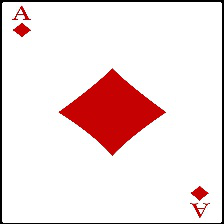

In [100]:
print(list(data.keys())[int(response[1])])
Image.open('1.jpg')